<a href="https://colab.research.google.com/github/FireStrings/MasterDegree/blob/main/CNN_LSTM/last_results/PFI_Gradients_Runner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Integrated Gradients
- Get feature importance
- Paper: https://arxiv.org/abs/1703.01365

In [ ]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

_dir = "/content/drive/My Drive/UFSCAR/Notebooks/CNN_LSTM"

import os
os.chdir(_dir)

Mounted at /content/drive/


### Imports

In [ ]:
%run CNN_LSTM.ipynb

Mounted at /content/drive/
Mounted at /content/drive/


In [ ]:
set_plot_size(15, 5)

In [ ]:
anual_df = load_and_filter("teresina", 7, 18).set_index("data_hora")

cols = ["temp_ins_c",
  "temp_max_c",
  "temp_min_c",
  "umi_ins_perc",
  "umi_max_perc",
  "umi_min_perc",
  "pto_orvalho_ins_c",
  "pto_orvalho_max_c",
  "pto_orvalho_min_c",
  "pressao_ins_hpa",
  "pressao_max_hpa",
  "pressao_min_hpa",
  "vel_vento_ms",
  "dir_vento_ms",
  "raj_vento_ms",
  "chuva_mm",
  "radiacao"]

df_selected = anual_df[cols]

df_selected = df_selected.rename(columns=
 {"temp_ins_c":"Temp. instantânea do ar",
  "temp_max_c": "Temp. máxima da última hora",
  "temp_min_c": "Temp. mínima da última hora",
  "umi_ins_perc": "Umidade relativa instantânea do ar",
  "umi_max_perc": "Umidade relativa máxima na última hora",
  "umi_min_perc": "Umidade relativa mínima na última hora",
  "pto_orvalho_ins_c": "Ponto de orvalho instantâneo",
  "pto_orvalho_max_c": "Ponto de orvalho máxima na última hora",
  "pto_orvalho_min_c": "Ponto de orvalho mínima na última hora",
  "pressao_ins_hpa": "Pressão atmosférica instantânea ao nível da estação",
  "pressao_max_hpa": "Pressão atmosférica máxima na última hora",
  "pressao_min_hpa": "Pressão atmosférica mínima na última hora",
  "vel_vento_ms": "Velocidade do vento",
  "dir_vento_ms": "Direção do vento",
  "raj_vento_ms": "Rajada do vento",
  "chuva_mm": "Volume de chuva acumulada na última hora"
 }
)

scaler = StandardScaler()

df_scaled = pd.DataFrame(scaler.fit_transform(df_selected), columns=df_selected.columns)
df_scaled = df_scaled.fillna(df_scaled.mean())

# X_train = df_scaled.drop("radiacao", axis=1).values
# X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

# Y_train = df_scaled["radiacao"].values

MSE: 0.18590430066625518
R² : 0.816358158677388

Importâncias das features:
                                              feature  importance_mean  \
0                             Temp. instantânea do ar         1.032880   
10          Pressão atmosférica máxima na última hora         0.223909   
12                                Velocidade do vento         0.201364   
1                         Temp. máxima da última hora         0.054415   
2                         Temp. mínima da última hora         0.048160   
3                  Umidade relativa instantânea do ar         0.044137   
7              Ponto de orvalho máxima na última hora         0.024377   
14                                    Rajada do vento         0.024207   
8              Ponto de orvalho mínima na última hora         0.024194   
9   Pressão atmosférica instantânea ao nível da es...         0.024036   
5              Umidade relativa mínima na última hora         0.012215   
11          Pressão atmosférica míni

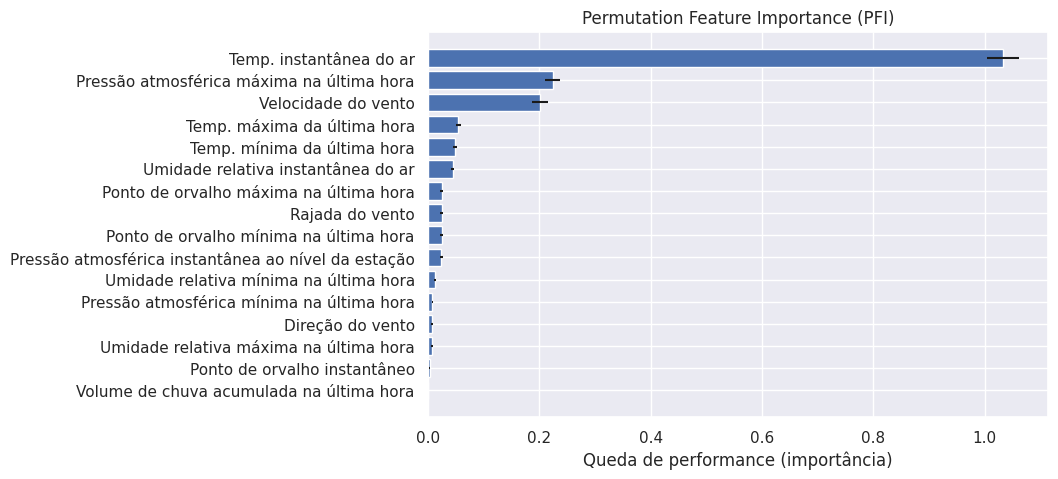

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

# 🔹 Exemplo: dataset fictício de previsão de radiação solar
# (substitua pelo seu dataset real)
np.random.seed(42)
n_samples = 500

# data = pd.DataFrame({
#     "temp": np.random.normal(25, 5, n_samples),
#     "humidity": np.random.uniform(20, 80, n_samples),
#     "wind": np.random.uniform(0, 10, n_samples),
#     "clouds": np.random.uniform(0, 1, n_samples),
# })

data = df_scaled

# Variável alvo (radiação solar em W/m²) simulada
# data["radiation"] = (
#     800
#     - 10 * data["clouds"] * 100
#     + 5 * data["temp"]
#     - 2 * data["humidity"]
#     + np.random.normal(0, 30, n_samples)
# )

data["radiation"] = data["radiacao"]

# 🔹 Divisão treino/teste
X = data.drop(columns=["radiation", "radiacao"])
y = data["radiation"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 🔹 Modelo
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Avaliação
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² :", r2_score(y_test, y_pred))

# 🔹 Permutation Feature Importance
pfi = permutation_importance(model, X_test, y_test, n_repeats=30, random_state=42)

# Criar dataframe de importâncias
importance_df = pd.DataFrame({
    "feature": X.columns,
    "importance_mean": pfi.importances_mean,
    "importance_std": pfi.importances_std
}).sort_values("importance_mean", ascending=False)

print("\nImportâncias das features:")
print(importance_df)

# 🔹 Plot
plt.figure(figsize=(8,5))
plt.barh(importance_df["feature"], importance_df["importance_mean"], xerr=importance_df["importance_std"])
plt.gca().invert_yaxis()
plt.xlabel("Queda de performance (importância)")
plt.title("Permutation Feature Importance (PFI)")
plt.show()
